<a href="https://colab.research.google.com/github/shyamsparrow/Jan-G4---NLP-Chatbot/blob/ALL_Models/Bert_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - NLP Chatbot

### DOMAIN: 
Industrial safety. NLP based Chatbot.

### CONTEXT:
The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

### DATA DESCRIPTION:
This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence of an accident.

### Columns description:
* Data: timestamp or time/date information
* Countries: which country the accident occurred (anonymised)
* Local: the city where the manufacturing plant is located (anonymised)
* Industry sector: which sector the plant belongs to
* Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
* Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have   been (due to other factors involved in the accident)
* Gender: if the person is male of female
* Employee or Third Party: if the injured person is an employee or a third party
* Critical Risk: some description of the risk involved in the accident
* Description: Detailed description of how the accident happened.

Link to download the dataset: https://drive.google.com/file/d/1_GmrRP1S2OIa02KlfOBNkYa8uxazGbfE/view?usp=sharing,
Original dataset link: https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database

### PROJECT OBJECTIVE:
Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident description.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replace the folder path with your drive folder path and clone the githb repo

Run the below code for clone the repo in our Googele drive for first time

In [2]:
! git clone https://github.com/shyamsparrow/Jan-G4---NLP-Chatbot.git

Cloning into 'Jan-G4---NLP-Chatbot'...
remote: Enumerating objects: 797, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 797 (delta 165), reused 219 (delta 98), pack-reused 452
Receiving objects: 100% (797/797), 292.72 MiB | 33.44 MiB/s, done.
Resolving deltas: 100% (398/398), done.
Checking out files: 100% (31/31), done.


Change the Current folder into Github repo main folder, all the functions we are calling has to be in this repo.

In [3]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


In [6]:
%cd /content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot

/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot


In [ ]:
#!git checkout Models

In [ ]:
#!git pull

Run this code to update the changes in repo to our drive

In [4]:
import warnings
warnings.filterwarnings('ignore')

import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [7]:
industry_df = pd.read_csv("industry_df_with_stopwords.csv")

In [28]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pickle

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, LSTM,  Embedding, Dropout, Bidirectional, GlobalMaxPool1D

from keras.utils import np_utils
from keras.layers.merge import Concatenate
#from keras.utils import plot_model

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Keras pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [8]:
# Select input and output features

X_text = industry_df['Description_preprocessed']
y_text = industry_df['Potential_Accident_Level']

In [9]:
# Encode labels in column 'Potential Accident Level'and Convert into one-hot encoded vectors:
le = LabelEncoder()
le.fit(y_text)
y_text = le.transform(y_text)
#y_text = np_utils.to_categorical(y_text)

In [10]:
# Divide our data into testing and training sets:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size = 0.20, random_state = 1)

print('X_text_train shape : ({0})'.format(X_text_train.shape))
print('y_text_train shape : ({0},)'.format(y_text_train.shape))
print('X_text_test shape : ({0})'.format(X_text_test.shape))
print('y_text_test shape : ({0},)'.format(y_text_test.shape))

X_text_train shape : ((328,))
y_text_train shape : ((328,),)
X_text_test shape : ((83,))
y_text_test shape : ((83,),)


In [11]:
# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_text_train)

In [ ]:
industry_df['nb_words'] = industry_df['Description_preprocessed'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(industry_df['nb_words'].min()))
print('Maximum number of words: {}'.format(industry_df['nb_words'].max()))

Minimum number of words: 16
Maximum number of words: 183


In [15]:
#Added 23.12.2021
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-8_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [16]:
#Added
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [13]:
#Added
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [17]:
#Added
!pip install sentencepiece

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
import os
import re
logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt


In [19]:
#Added
import tensorflow_hub as hub
import tokenization
bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1, Total size: 320.89MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1'.


In [20]:
#Added
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [21]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    output = bert_layer({'input_word_ids':input_word_ids,
                                                 'input_mask': input_mask, 
                                                 'input_type_ids': segment_ids})
    clf_output = output['pooled_output']
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
max_len = 200
#X_text_train, X_text_test, y_text_train, y_text_test
train_input = bert_encode(X_text_train, tokenizer, max_len=max_len)
test_input = bert_encode(X_text_test, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(y_text_train)
test_labels = tf.keras.utils.to_categorical(y_text_test)

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 200)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 keras_layer_5 (KerasLayer)     {'encoder_outputs':  81130753    ['input_mask[0][0]',             
                                 [(None, 200, 768),               'input_type_ids[0][0]',   

In [ ]:
history = model.fit(train_input, train_labels, epochs=20,
          validation_split=0.2,
          batch_size=32)

Epoch 1/20
9/9 [==============================] - 490s 52s/step - loss: 1.6689 - accuracy: 0.2023 - val_loss: 1.5483 - val_accuracy: 0.2121
Epoch 2/20
9/9 [==============================] - 462s 51s/step - loss: 1.4910 - accuracy: 0.2939 - val_loss: 1.4958 - val_accuracy: 0.3030
Epoch 3/20
9/9 [==============================] - 465s 52s/step - loss: 1.4316 - accuracy: 0.3664 - val_loss: 1.4740 - val_accuracy: 0.3182
Epoch 4/20
9/9 [==============================] - 474s 52s/step - loss: 1.3958 - accuracy: 0.3931 - val_loss: 1.4660 - val_accuracy: 0.3030
Epoch 5/20
9/9 [==============================] - 476s 53s/step - loss: 1.4030 - accuracy: 0.3511 - val_loss: 1.4547 - val_accuracy: 0.3636
Epoch 6/20
9/9 [==============================] - 470s 52s/step - loss: 1.3470 - accuracy: 0.4122 - val_loss: 1.4307 - val_accuracy: 0.3636
Epoch 7/20
9/9 [==============================] - 477s 53s/step - loss: 1.3178 - accuracy: 0.4198 - val_loss: 1.4308 - val_accuracy: 0.3939
Epoch 8/20
9/9 [====

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


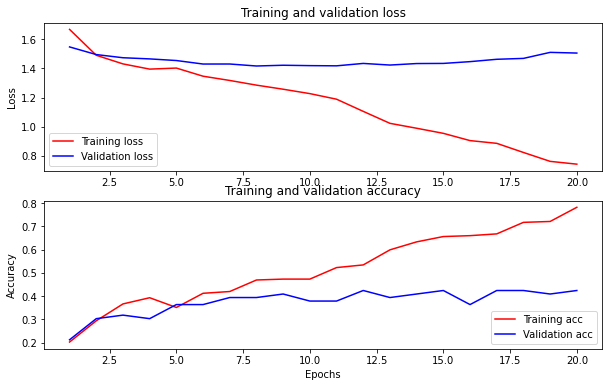

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
preds = np.argmax(model.predict(test_input, batch_size=16), axis=1)

In [ ]:
model.save("BERT_model.h5")

In [ ]:
_, train_accuracy = model.evaluate(train_input, train_labels, batch_size=8, verbose=0)
_, test_accuracy = model.evaluate(test_input, test_labels, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 79.27
Test accuracy: 40.96


In [ ]:
y_original = np.argmax(test_labels, axis =1)

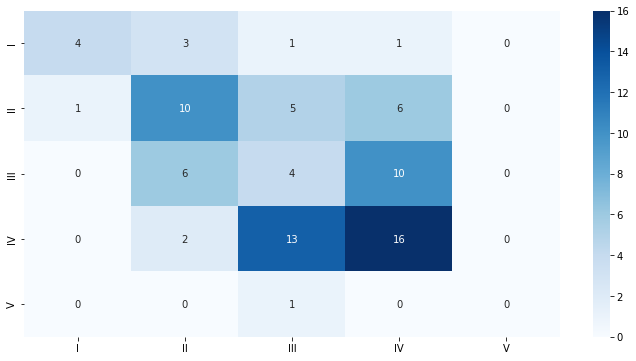

In [ ]:
cm = confusion_matrix(y_original,preds)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);

In [ ]:
print(classification_report(y_original, preds))

              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.48      0.45      0.47        22
           2       0.17      0.20      0.18        20
           3       0.48      0.52      0.50        31
           4       0.00      0.00      0.00         1

    accuracy                           0.41        83
   macro avg       0.39      0.32      0.34        83
weighted avg       0.43      0.41      0.42        83



In [ ]:
F1_sre= f1_score(y_original,preds, average='micro')
train_accuracy,test_accuracy,F1_sre

(0.792682945728302, 0.40963855385780334, 0.4096385542168675)

In [ ]:
df2=pd.read_csv('Results_df.csv',index_col=False)

In [ ]:
df2=df2.drop(['Unnamed: 0'],axis=1)

In [ ]:
df2.loc[len(df2.index)] = ['BERT_Model', train_accuracy, test_accuracy,F1_sre] 
df2

,Model,Train_accuracy,Test_accuracy,F1_score
0,LogReg,0.890244,0.890244,0.373494
1,Naive Bayes,1.000000,1.000000,0.421687
2,KNN,0.591463,0.591463,0.361446
3,SVM,0.990854,0.990854,0.361446
4,Decision Tree,0.512195,0.512195,0.313253
5,RandomForest,0.612805,0.612805,0.373494
6,Bagging,1.000000,1.000000,0.373494
7,AdaBoost,0.393293,0.393293,0.349398
8,Gradient Boost,0.920732,0.920732,0.325301
9,XGBoost,0.951220,0.951220,0.313253


In [34]:
from sklearn.metrics import roc_curve, auc

In [31]:
%cd /content/drive/MyDrive/AIML/Capstone

from keras.models import load_model
model = load_model('BERT_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

/content/drive/MyDrive/AIML/Capstone


In [32]:
preds_new = model.predict(test_input)

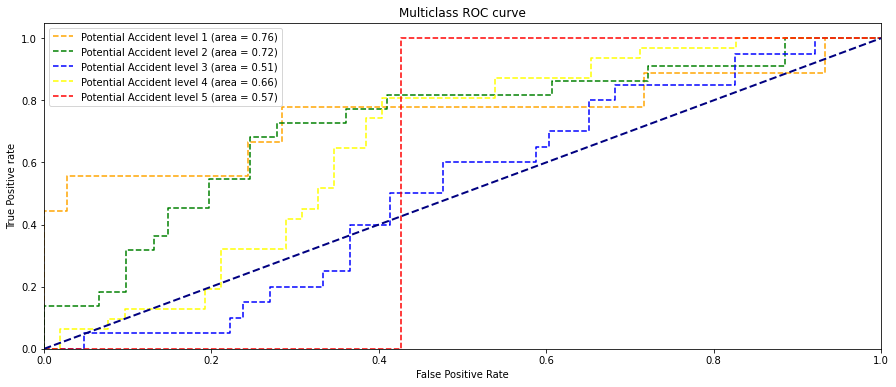

In [35]:
#Added
fpr = {}
tpr = {}
#thresh ={}
roc_auc = dict()

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i],_ = roc_curve(test_labels[:,i], preds_new[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plotting  
plt.figure(figsize=(15, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label="Potential Accident level 1 (area = %0.2f)" % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="Potential Accident level 2 (area = %0.2f)" % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label="Potential Accident level 3 (area = %0.2f)" % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label= "Potential Accident level 4 (area = %0.2f)" % roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label="Potential Accident level 5 (area = %0.2f)" % roc_auc[4])

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc="lower right")
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);